In [1]:
# basic packages
import pandas as pd
import os
import warnings
import pyarrow as pa
import pyarrow.parquet as pq
warnings.filterwarnings("ignore")

#Shared/Utility scripts
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from model_scripts import Simple_Eval, dataloader, dataprocessor, xgb_model #had to pip install xgboost
HOME = os.path.expanduser('~')

modelname = 'XGBoost'
model_path = f"{HOME}/SWEMLv2.0/Model/{modelname}"
if not os.path.exists(model_path):
    os.makedirs(model_path, exist_ok=True)
print(f"{modelname} development script, {device}")

Device: cuda
Device: cuda
XGBoost development script, cuda


In [20]:
#load data
regionlist = ['SouthernRockies', 'Southwest', 'Northwest']
output_res = '300M_Resolution'
DataFrame = 'Vegetation_Sturm_Seasonality_PrecipVIIRSGeoObsDFs'
fSCA_thresh = '20_fSCA_Thresh'
remove0swe = True #set to False to use all data, set to True to remove values under a certain threshold
removeswe_thresh = 1 #value in cm to remove ASO obs/rows from. 

alldata = dataloader.get_ML_Data(regionlist, output_res, DataFrame, fSCA_thresh)

#small adjustments to correct some data
#aspect
alldata['Aspect_Deg'] = alldata['Aspect_Deg']-270
df = alldata[alldata['Aspect_Deg']>= 0]
df['Aspect_Deg'] = abs(df['Aspect_Deg']-90)+270
alldata.update(df)
alldata['Aspect_Deg'] = abs(alldata['Aspect_Deg'])

#Precip - looks like its in inches
alldata['season_precip_cm'] = alldata['season_precip_cm']*2.54

'''for Vegetation_Sturm_Seasonality_PrecipVIIRSGeoObsDFs, ASO obs
put SW 2018-04-22, 2018-03-04, San Joaquin, in bad data folder seems too big for peaks
in Southern Rockies 2019-04-07, East River, way too high of values, put in bad data folder'''

Concatenating 13 for the model dataframe development.


  0%|          | 0/13 [00:00<?, ?it/s]

There are 271579 datapoints for model training/testing in the SouthernRockies modeling domain.
Concatenating 97 for the model dataframe development.


  0%|          | 0/97 [00:00<?, ?it/s]

There are 2184173 datapoints for model training/testing in the Southwest modeling domain.
Concatenating 2 for the model dataframe development.


  0%|          | 0/2 [00:00<?, ?it/s]

There are 170370 datapoints for model training/testing in the Northwest modeling domain.
There are 2626122 datapoints for model training/testing in the overall modeling domain.


'for Vegetation_Sturm_Seasonality_PrecipVIIRSGeoObsDFs, ASO obs\nput SW 2018-04-22, 2018-03-04, San Joaquin, in bad data folder seems too big for peaks\nin Southern Rockies 2019-04-07, East River, way too high of values, put in bad data folder'

## Pull out a test condition by date

In [30]:
# Pulling out 3-29-2019 in Southwest
#date = '2019-03-29' # Merced
#date = '2019-04-19' # Blue
date = '2019-03-25' # Taylor
TestArea = alldata[alldata['Date'] == date]
TestArea.reset_index(inplace=True, drop=True)

#remove Test area data from training/testing dataset
df = pd.concat([alldata, TestArea]).drop_duplicates(keep=False)

# Data Processing

In [31]:
#clean the data
df = dataprocessor.data_clean(df, regionlist)
df.head()

#temporary for seasonality relationship
df.fillna(1, inplace = True)

#convert dates to datetime format
df.Date = pd.to_datetime(df.Date)

input_columns = [
            'cen_lat',	
            'cen_lon',	
            'Elevation_m',	
            'Slope_Deg',	
            'Aspect_Deg',	
            'ns_1',	
            'ns_2',	
            'ns_3',	
            'ns_4',	
            'ns_5',	
            #'ns_6',	
            #'VIIRS_SCA', 
            'hasSnow',
            'season_precip_cm',
            'region_class',
            'DOS', 
            'WY_week',
            'ns_1_week_mean', 
            'ns_2_week_mean', 
            'ns_3_week_mean', 
            'ns_4_week_mean',
            'ns_5_week_mean', 
            #'ns_6_week_mean', 
            'Seasonal_ns_1_rel',
            'Seasonal_ns_2_rel',
            'Seasonal_ns_3_rel', 
            'Seasonal_ns_4_rel',
            'Seasonal_ns_5_rel', 
            #'Seasonal_ns_6_rel',
            'sturm_value',
           # 'vegetation_value'
]



years = False
splitratio = 0.1
test_years = [2019]
target = 'swe_cm'
remove0swe = True #set to False to use all data, set to True to remove values under a certain threshold
removeswe_thresh = 1 #value in cm to remove ASO obs/rows from. 
#remove the large amounts of zero values
df = dataloader.remove0swe(df, remove0swe, removeswe_thresh)


#fit a scaler,save, and scale the training data
x_train, y_train, x_test, y_test = dataprocessor.xgb_processor(
                                                    regionlist,
                                                      df, 
                                                      years, 
                                                      splitratio,
                                                      test_years, 
                                                      target, 
                                                      input_columns, 
                                                      model_path, 
                                                      scalertype = 'MinMax'
                                                      )

The provided data contains 2603429 data points, of which 371330 locations/timesteps show no SWE and VIIRS fsca > 20%
271020 locations/timesteps show SWE and VIIRS fsca < 20%
0 locations/timesteps show SWE greater than a realistic value (250 cm) in the SouthernRockies domain
20 locations/timesteps show SWE greater than a realistic value (400 cm) in the Southwest domain
47 locations/timesteps show SWE greater than a realistic value (800 cm) in the Northwest domain
removing..
There are 1961032 datapoints for model training/testing.
There are 843699 in the training dataset, removing 1117333 zero values in the ASO dataset, VIIRS fSCA will capture these.


# Train Model

In [ ]:
#Train model
tries = 1 #what is tries?
hyperparameters = {
    'max_depth': [8], #range (10, 21, 5),
    'n_estimators': [3500], #range(500, 1600, 500),
    'eta': [0.1,]
}
perc_data = 0.25 # percent of training data used to identify optimal hyperparameters

Use_fSCA_Threshold = True

xgb_model.XGB_Train(model_path, 
                    input_columns, 
                    x_train, 
                    y_train, 
                    tries, 
                    hyperparameters,
                    perc_data)

#Make a prediction for each location, save as compressed pkl file, and send predictions to AWS for use in CSES
PredsDF = pd.DataFrame()
PredsDF = xgb_model.XGB_Predict(
                    model_path, 
                    modelname, 
                    x_test,
                    y_test,
                    Use_fSCA_Threshold
                    )

Trial Number 0 ==========================================================
Tuning hyperparametetrs on 25.0% of training data
Fitting 3 folds for each of 1 candidates, totalling 3 fits


1000


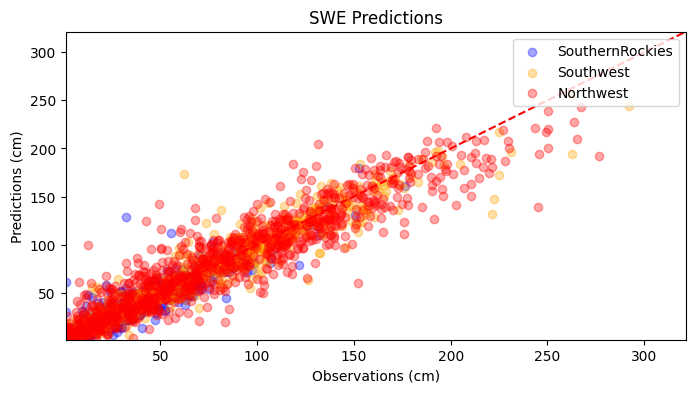

,region,XGBoost_swe_cm_kge,XGBoost_swe_cm_rmse,XGBoost_swe_cm_mape,XGBoost_swe_cm_pbias
0,Overall,0.93,15.0,33.93,0.07
0,SouthernRockies,0.91,8.0,37.97,-0.84
0,Southwest,0.95,12.0,25.90,0.46
0,Northwest,0.90,21.0,37.92,0.11


In [ ]:
#Take a sample to determine model skill - Take 1000 from each modeling domain
n_samples = 1000
SampleDF, PredsDF = Simple_Eval.SamplePreds(regionlist, PredsDF, df, n_samples)


savfig = True
figname = 'Model-Testing-Split-Performance'

 #Evaluate model performance of the different models
prediction_columns = [f"{modelname}_swe_cm"]
Eval_DF = Simple_Eval.Simple_Eval(regionlist,
                                SampleDF,
                                prediction_columns, 
                                modelname, 
                                savfig, 
                                figname,
                                plots = False, 
                                keystats = False        
                                )

In [20]:
Ppath = f"{HOME}/SWEMLv2.0/Predictions/{DataFrame}/{output_res}/{fSCA_thresh}"
if not os.path.exists(Ppath):
    os.makedirs(Ppath, exist_ok=True)


#save the model predictions
table = pa.Table.from_pandas(PredsDF)
# Parquet with Brotli compression
pq.write_table(table, f"{Ppath}/Test_preds.parquet", compression='BROTLI')

## Make a prediction on the held out date


In [ ]:

#Prep prediction data
y_test_Area = pd.DataFrame(TestArea['swe_cm'])
dropcols = ['cell_id',	'Date', 'swe_cm', 'region']
x_test_Area = TestArea.drop(columns=dropcols)
x_test_Area = x_test_Area[input_columns]

#make a prediction
holdoutdate = xgb_model.XGB_Predict(
                    model_path, 
                    modelname, 
                    x_test_Area,
                    y_test_Area,
                    Use_fSCA_Threshold
                    )
#Add geospatial information to prediction DF
EvalDF = pd.concat([TestArea, holdoutdate], axis=1)
#EvalDF.drop(['index'], axis=1, inplace=True)
EvalDF = EvalDF.loc[:,~EvalDF.columns.duplicated()].copy()

EvalDF.head(5)

Ppath = f"{HOME}/SWEMLv2.0/Predictions/{DataFrame}/{output_res}/{fSCA_thresh}"
if not os.path.exists(Ppath):
    os.makedirs(Ppath, exist_ok=True)


#save the model predictions
table = pa.Table.from_pandas(EvalDF)
# Parquet with Brotli compression
pq.write_table(table, f"{Ppath}/0SWEthresh_All_Feats_HoldOut_{date}.parquet", compression='BROTLI')

Model Predictions complete


In [29]:
EvalDF

,cell_id,Date,cen_lat,cen_lon,Elevation_m,Slope_Deg,Aspect_Deg,ns_1,ns_2,ns_3,...,Seasonal_ns_4_rel,Seasonal_ns_5_rel,Seasonal_ns_6_rel,sturm_value,vegetation_value,swe_cm,region,region_class,ASO_swe_cm,XGBoost_swe_cm
